# Read and Join all networks

In [21]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import os
import numpy as np

def read_edge(filename, net_name, filter_percent = False):
    # skip first line header!!
    if filter_percent:
        # refseq and eskape needs to be filtered. below 70% there's basically nothing
        edge = pd.read_csv(filename, header = None, names = ['source', 'target', net_name])
        edge = edge.loc[edge[net_name]>np.percentile(edge[net_name], q = 70)]
        net = nx.from_pandas_edgelist(edge, edge_attr = [net_name])
    else:
        with open(filename, 'rb') as f:
      
            net = nx.read_edgelist(f, delimiter = ',',nodetype = int, comments = '#', data = [(net_name, float)])
    return net



In [22]:
# combine all nets together
base_path = '/home/hermuba/nas2/resist_subnet/'
all_net = {}
for i, net_name in enumerate(['string', 'refseq', 'eskape', 'domain']):
    if net_name == 'refseq' or net_name == 'eskape' or net_name == 'domain':
        all_net[net_name] = read_edge(os.path.join(base_path, net_name, 'network.csv'), net_name, filter_percent = True)
    else:
        all_net[net_name] = read_edge(os.path.join(base_path, net_name, 'network.csv'), net_name, filter_percent = False)
    
    if i == 0:
        combined = all_net[net_name]
    else:
        combined = nx.compose(combined, all_net[net_name])


In [23]:
# integrate gosim as well
gosim_df = pd.read_csv(os.path.join(base_path, 'gosim.csv'), sep = ' ', names = ['gene_id1', 'gene_id2', 'gosim'], skiprows = 1 )
gosim = nx.from_pandas_edgelist(gosim_df, source = 'gene_id1', target = 'gene_id2',  edge_attr='gosim')
combined = nx.compose(combined, gosim)

# Convert to dataframe 

In [24]:
edges_prediction = nx.to_pandas_edgelist(combined)
# we only consider those with at least 1 network prediction
edges_prediction = edges_prediction.loc[edges_prediction[['string', 'refseq', 'eskape', 'domain']].count(axis = 1)>0]

In [25]:
edges_prediction.shape

(1614357, 7)

In [26]:
edges_prediction.count() # the data is sparse, about half has gosim socre.

source    1614357
target    1614357
domain     742554
refseq    1218803
eskape    1328040
gosim      784530
string      48267
dtype: int64

# Machine Learning

In [27]:
# normalize for training
def normalize(df, features = ['string', 'refseq', 'eskape', 'domain']):
    normalized = pd.DataFrame(columns = df.columns, index = df.index)
    for col in features:
        z_score = (df[col]-df[col].mean())/df[col].std()
        normalized[col] = z_score
    normalized[['source', 'target', 'gosim']] = df[['source', 'target', 'gosim']] 
    return normalized

normalized_edges = normalize(edges_prediction)

In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
complete_data = normalized_edges.loc[normalized_edges[['string', 'refseq', 'eskape', 'domain']].count(axis = 1) == 4]
balance = complete_data.loc[complete_data['gosim'].notnull()]
print(balance.size)
X = balance[['string', 'refseq', 'eskape', 'domain']].fillna(0)
y = balance['gosim']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
regr = LinearRegression().fit(X_train, y_train)
regr.score(X_test, y_test)

147896


0.09192683513396493

In [29]:
regr.coef_ #['string', 'refseq', 'eskape', 'domain']

array([0.03415015, 0.00784235, 0.00242091, 0.0225782 ])

<AxesSubplot:>

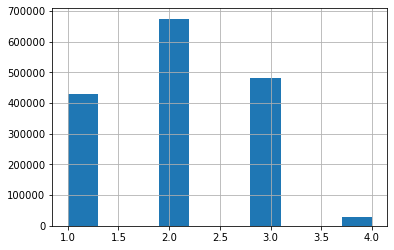

In [30]:
normalized_edges[['string', 'refseq', 'eskape', 'domain']].count(axis = 1).hist()

In [31]:
from sklearn.neural_network import MLPRegressor
complete_data = normalized_edges.loc[normalized_edges[['string', 'refseq', 'eskape', 'domain']].count(axis = 1) == 4]
balance = complete_data.loc[complete_data['gosim'].notnull()]
X = balance[['string', 'refseq', 'eskape', 'domain']].fillna(0)
y = balance['gosim']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
nnregr = MLPRegressor(hidden_layer_sizes = (10,50,50,10), random_state=1, max_iter=50,warm_start = True, verbose = True, early_stopping = True).fit(X_train, y_train)
nnregr.score(X_test, y_test)

Iteration 1, loss = 0.15137486
Validation score: -0.000372


/home/hermuba/miniconda3/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:573: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


-0.17541125470433738

In [32]:
def quantile(df, q = 100):
    qdf = pd.DataFrame(columns = df.columns, index = df.index)
    for col in ['string', 'refseq', 'eskape', 'domain']:
        qs = pd.qcut(df[col], q = q, retbins = False, labels = False, duplicates = 'drop')
        
        qdf.loc[df.index, col] = qs.fillna(-1)
        
       
    qdf['gosim'] = df['gosim']
    qdf['target'] = df['target']
    qdf['source'] = df['source']
    return qdf

In [33]:
def downsample_low_score(trainable):
    low_score = trainable.loc[trainable['gosim']<0.2].shape[0]
    higher_score = trainable.loc[trainable['gosim']>0.2].shape[0]*2
    to_discard = trainable.loc[trainable['gosim']<0.2].sample(low_score-higher_score).index
    return trainable.drop(to_discard, axis =0)

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
q_score = quantile(edges_prediction, q =1000)
balance = q_score.loc[q_score['gosim'].notnull()]
#balance = downsample_low_score(q_score.loc[q_score['gosim'].notnull()])
X = balance[['string', 'refseq', 'eskape', 'domain']]
y = balance['gosim']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

for hsize in [(10,20,10), (10,20,20,10), (10,50,50,10), (20,50,50,20,10), (10, 20,50,50,20,10), (10,20,50,50,20,10, 10)]:
    nnregr = MLPRegressor(hidden_layer_sizes = hsize , random_state=1, max_iter=200,warm_start = True, verbose = False, early_stopping = True).fit(X_train, y_train)
    print(hsize, nnregr.score(X_test, y_test), nnregr.score(X_train, y_train))

(10, 20, 10) 0.0026628350726201067 0.0027370161827149353
(10, 20, 20, 10) 0.045996626794880036 0.04701358050465432


In [25]:
import time
current = 0
best_model = None
for n in range(10):
    nnregr = MLPRegressor(hidden_layer_sizes = (10,50,50,10) , random_state=int(time.time()), max_iter=200,warm_start = False, verbose = False, early_stopping = True).fit(X_train, y_train)
    print((10,50,50,10), nnregr.score(X_test, y_test), nnregr.score(X_train, y_train))
    if nnregr.score(X_test, y_test) > current:
        best_model = nnregr
        current = nnregr.score(X_test, y_test)

/home/hermuba/miniconda3/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:573: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


(10, 20, 50, 50, 20, 10, 10) -0.002809405172385482 -0.0028815664561507854


/home/hermuba/miniconda3/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:573: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


AttributeError: 'MLPRegressor' object has no attribute '_best_coefs'

In [ ]:
from scipy.stats import pearsonr
prediction = best_model.predict(q_score[['string', 'refseq', 'eskape', 'domain']])
q_score['total_score'] = prediction
plt.scatter(q_score['gosim'], prediction)
pearsonr(q_score.dropna(subset =['gosim'])['gosim'].values,q_score.dropna(subset =['gosim'])['total_score'].values)

d = try_thres(q_score, 'total_score')
d.to_csv(os.path.join(base_path, 'preformance', '{}.ppv_cov.csv'.format('totalnn')))

In [34]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
q_score = quantile(edges_prediction, q =300)
balance = q_score.loc[q_score['gosim'].notnull()]
#balance = downsample_low_score(q_score.loc[q_score['gosim'].notnull()])
X = balance[['string', 'refseq', 'eskape', 'domain']]
y = balance['gosim']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
rfregr = RandomForestRegressor(max_depth=2, random_state=0, verbose = True)
rfregr.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   38.6s finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=2, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=True, warm_start=False)

In [35]:
rfregr.score(X_test, y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished


0.13301832054857965

In [36]:
from scipy.stats import pearsonr
pearsonr(rfregr.predict(X_test), y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished


(0.3647680372387565, 0.0)

In [38]:
performance = {}
best_model = rfregr
current = rfregr.score(X_test, y_test)
import time
for depth in range(3,20,3):
    rf = RandomForestRegressor(max_depth=depth, random_state=int(time.time()), verbose = True)
    rf.fit(X_train, y_train)
    performance[depth] = rf.score(X_test, y_test)
    print(depth, performance[depth])
    if performance[depth] > current:
        best_model = rf
        current = rf.score(X_test, y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   55.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


3 0.1375005209250557


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


6 0.14320428811077535


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  2.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


9 0.14653858735757352


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  3.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


12 0.14721009644837912


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  3.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.3s finished


15 0.1454063565623992


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  4.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


18 0.1407240160092189


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    4.8s finished


In [39]:
performance

{3: 0.1375005209250557,
 6: 0.14320428811077535,
 9: 0.14653858735757352,
 12: 0.14721009644837912,
 15: 0.1454063565623992,
 18: 0.1407240160092189}

Text(0.5, 1.0, 'Random Forest Classifier')

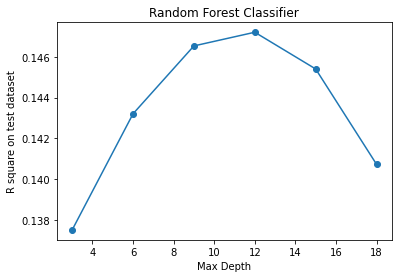

In [40]:
import collections
od = collections.OrderedDict(sorted(performance.items()))
plt.plot(od.keys(), od.values(), marker = 'o')
plt.xlabel('Max Depth')
plt.ylabel('R square on test dataset')
plt.title('Random Forest Classifier')

In [41]:
annotation_df = os.path.join(base_path, 'gold_anno.csv')
gold_anno = pd.read_csv(annotation_df)
def PPV(computable, subset = None):
    if subset:
        subcomputable = computable.loc[(computable['target'].isin(subset))|(computable['source'].isin(subset))]
    else:
        subcomputable = computable.copy()
    grouped = subcomputable.groupby(by = ['goldstandard', 'prediction']).count()['target']
    
    try:
        tp = grouped[True, True]
        fp = grouped[False, True]
        PPV = tp/(tp+fp)
        
       
    except KeyError:
        PPV = 0
        
    return PPV

def coverage(computable, all_nodes):
    net = computable.loc[computable['prediction']]
    covered_nodes = set(net['source']).union(net['target']).intersection(all_nodes)
    
    return len(covered_nodes)/len(all_nodes)
    
def PPV_coverage(df, score_col, score_thres, gold_col = 'gosim', gold_thres = 0.6):
    ''' define goldstandard_score > gold_thres as Positive. d'''
    
    # write prediction
    computable = df.loc[(df[score_col].notnull())&(df[gold_col].notnull())]
    computable['prediction'] = df[score_col]>score_thres
    computable['goldstandard'] = df[gold_col]>gold_thres

    
    # total
    ppv = PPV(computable)
    cov = coverage(computable, set(gold_anno['gene_id']))
    
    # core
    core_genes = set(gold_anno.loc[gold_anno['core'], 'gene_id'])
    core_ppv = PPV(computable, subset = core_genes)
    core_cov = coverage(computable, core_genes)
    
    # acc
    acc_genes = set(gold_anno.loc[~gold_anno['core'], 'gene_id'])
    acc_ppv = PPV(computable, subset = acc_genes)
    acc_cov = coverage(computable, acc_genes)
    
    return ppv, core_ppv, acc_ppv, cov, core_cov, acc_cov

def try_thres(df, col, q = 300, interval = 10):
    tradeoff = []

    _, bins = pd.qcut(df[col], q = q, retbins = True, duplicates = 'drop')
    
    for bi in range(0, len(bins), interval):
        
        b = bins[bi]
        scores = PPV_coverage(df, col, b)
        tradeoff.append([b]+list(scores))
    return pd.DataFrame(tradeoff, columns = ['{}_score'.format(col), 'ppv', 'core_ppv', 'acc_ppv', 'cov', 'core_cov', 'acc_cov'])
    

In [42]:
from scipy.stats import pearsonr
prediction = best_model.predict(q_score[['string', 'refseq', 'eskape', 'domain']])
q_score['total_score'] = prediction
#plt.scatter(q_score['gosim'], prediction)
#pearsonr(q_score.dropna(subset =['gosim'])['gosim'].values,q_score.dropna(subset =['gosim'])['total_score'].values)

d = try_thres(q_score, 'total_score')
d.to_csv(os.path.join(base_path, 'preformance', '{}.ppv_cov.csv'.format('totalrf')))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   14.8s finished
/home/hermuba/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/hermuba/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [43]:
q_score.to_csv('~/nas2/integrate_net/rf.csv')

<AxesSubplot:>

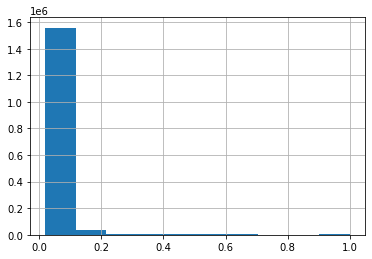

In [44]:
q_score['total_score'].hist()

In [45]:
acc_id = gold_anno.loc[~gold_anno['core'], 'gene_id']

In [53]:
q_score.loc[(q_score['total_score']>0.6)].to_csv('~/nas2/integrate_net/rf_greater_than_06.csv')

In [46]:
q_score.loc[(q_score['total_score']>0.6) & (q_score['target'].isin(acc_id)) & (q_score['source'].isin(acc_id))].to_csv('~/nas2/integrate_net/rf_greater_than_06_acc.csv')

In [54]:
q_score.loc[(q_score['total_score']>0.1)].to_csv('~/nas2/integrate_net/rf_greater_than_01.csv')

In [47]:
q_score.loc[q_score['total_score']>0.7].shape

(4346, 8)

In [49]:
rf_network = nx.from_pandas_edgelist(q_score.loc[q_score['total_score']>0.7], edge_attr=['string', 'refseq', 'eskape', 'domain', 'total_score'])

In [48]:
for net in ['string', 'refseq', 'eskape', 'domain']:
    print(net, sum(q_score[net]!=-1))

string 48267
refseq 1218803
eskape 1328040
domain 742554


In [50]:
import numpy as np

eskape = rf.predict(np.array([[-1,-1,i,-1] for i in range(300)]))

refseq = rf.predict(np.array([[-1,i,-1,-1] for i in range(300)]))
string = rf.predict(np.array([[i,-1,-1,-1] for i in range(300)]))
domain = rf.predict(np.array([[-1,-1,-1,i] for i in range(300)]))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


Text(0.5, 1.0, 'when other network has no data')

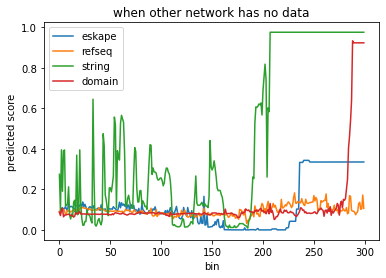

In [51]:
plt.plot(eskape, label = 'eskape')
plt.plot(refseq, label = 'refseq')
plt.plot(string, label = 'string')
plt.plot(domain, label = 'domain')
plt.legend()
plt.xlabel('bin')
plt.ylabel('predicted score')
plt.title('when other network has no data')

In [52]:
pearsonr(best_model.predict(X_test), y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.5s finished


(0.3836822755947916, 0.0)

In [ ]:
# scikit-learn 